<a href="https://colab.research.google.com/github/MarkoBrie/Image-Classification-with-CNN-and-data-augmentation/blob/main/Image_classification_with_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a name='0'></a>
# Sommaire

- [ Sommaire](#0)
- [ 1 - Configurer le noyau et les dépendances nécessaires](#1)
- [ 2 - Préparation du jeu de donnée](#2)
  - [ 2.0 - Charger le jeu de donnée CSV avec catégorie](#2.0)
  - [ 2.1 - Charger les images](#2.1)
  - [ 2.2 - Charger le jeu de donnée CSV avec catégorie](#2.2)
  - [ 2.3 - Afficher quelques exemples d'images par catégories](#2.3)
- [ 3 - SIFT, Clustering et ARI](#3)
  - [ 3.1 - Détermination et affichage des descripteurs SIFT](#3.1)
  - [ 3.2 - Classification d'images](#3.2)
- [ 4 - Perform Fine-Tuning to Detoxify the Summaries](#4)
  - [ 4.1 - Création des features des images](#4.1)
  - [ 4.2 - Réduction de dimension et analyse](#4.2)
    - [ 4.2.1 - Réduction de dimension avec PCA](#4.2.1)
    - [ 4.2.2 - Réduction de dimension T-SNE et affichage des images selon vraies classes](#4.2.1)
      
  - [ 3.4 - Evaluate the Model Qualitatively](#3.4)

<a name='1'></a>
# 1 - Configurer le noyau et les dépendances nécessaires

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, auc, roc_auc_score, roc_curve
from glob import glob

from sklearn import preprocessing

import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, GlobalAveragePooling1D, Flatten, Dense, Dropout
from tensorflow.keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical

# os.environ["TF_KERAS"]='1'
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


<a name='2'></a>
# 2 Préparation du jeu de donnée

<a name='2.0'></a>
## 2.0 Télécharger le jeu de donnée zipped et unzip

In [2]:
import requests
import zipfile
import io
import os

# URL of the zip file
zip_url = 'https://s3-eu-west-1.amazonaws.com/static.oc-static.com/prod/courses/files/Parcours_data_scientist/Projet+-+Textimage+DAS+V2/Dataset+projet+pre%CC%81traitement+textes+images.zip'

# Destination folder to extract the files
destination_folder = './'

# Create the destination folder if it doesn't exist
os.makedirs(destination_folder, exist_ok=True)

# Download the zip file
response = requests.get(zip_url)

# Check if the download was successful
if response.status_code == 200:
    # Unzip the content
    with zipfile.ZipFile(io.BytesIO(response.content)) as zip_ref:
        zip_ref.extractall(destination_folder)
    print("Zip file successfully downloaded and extracted.")
else:
    print(f"Failed to download the zip file. Status code: {response.status_code}")

Zip file successfully downloaded and extracted.


<a name='2.1'></a>
## 2.1 Charger les images

In [ ]:
path = "./Flipkart/Images"
print(path)

data_path = os.listdir(path)
#print(data_path)

./Flipkart/Images


<a name='2.2'></a>
## 2.2 Charger le jeu de donnée CSV avec catégorie

In [ ]:
# Specify the path to your CSV file
file_path = './Flipkart/flipkart_com-ecommerce_sample_1050_with_CAT.csv'

# Read the CSV file into a pandas DataFrame
df = pd.read_csv(file_path)

# Display the first few rows of the DataFrame
#print(df.head(2))

In [ ]:
# L'éxtraction des noms de catégorie
l_cat = list(set(df['product_category_tree_1']))
print("catégories : ", l_cat)

list_labels = l_cat
label_no_name = "no_name "
print('Number of categories : ', len(l_cat))

catégories :  ['Home Furnishing', 'Computers', 'Watches', 'Kitchen & Dining', 'Beauty and Personal Care', 'Baby Care', 'Home Decor & Festive Needs']
Number of categories :  7


In [ ]:
df['image_path'] = './Flipkart/Images/' + df['image']
df['image_dir'] = './Flipkart/Images/'

In [ ]:
le = preprocessing.LabelEncoder()
le.fit(df["product_category_tree_1"])
df["label"] = le.transform(df["product_category_tree_1"])

In [ ]:
df

,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_tree_1,image_path,label
0,55b85ea15a1536d46b7190ad6fff8ce7,2016-04-30 03:22:56 +0000,http://www.flipkart.com/elegance-polyester-mul...,Elegance Polyester Multicolor Abstract Eyelet ...,"[""Home Furnishing >> Curtains & Accessories >>...",CRNEG7BKMFFYHQ8Z,1899.0,899.0,55b85ea15a1536d46b7190ad6fff8ce7.jpg,False,Key Features of Elegance Polyester Multicolor ...,No rating available,No rating available,Elegance,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,./Flipkart/Images/55b85ea15a1536d46b7190ad6fff...,4
1,7b72c92c2f6c40268628ec5f14c6d590,2016-04-30 03:22:56 +0000,http://www.flipkart.com/sathiyas-cotton-bath-t...,Sathiyas Cotton Bath Towel,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEGFZHGBXPHZUH,600.0,449.0,7b72c92c2f6c40268628ec5f14c6d590.jpg,False,Specifications of Sathiyas Cotton Bath Towel (...,No rating available,No rating available,Sathiyas,"{""product_specification""=>[{""key""=>""Machine Wa...",Baby Care,./Flipkart/Images/7b72c92c2f6c40268628ec5f14c6...,0
2,64d5d4a258243731dc7bbb1eef49ad74,2016-04-30 03:22:56 +0000,http://www.flipkart.com/eurospa-cotton-terry-f...,Eurospa Cotton Terry Face Towel Set,"[""Baby Care >> Baby Bath & Skin >> Baby Bath T...",BTWEG6SHXTDB2A2Y,NaN,NaN,64d5d4a258243731dc7bbb1eef49ad74.jpg,False,Key Features of Eurospa Cotton Terry Face Towe...,No rating available,No rating available,Eurospa,"{""product_specification""=>[{""key""=>""Material"",...",Baby Care,./Flipkart/Images/64d5d4a258243731dc7bbb1eef49...,0
3,d4684dcdc759dd9cdf41504698d737d8,2016-06-20 08:49:52 +0000,http://www.flipkart.com/santosh-royal-fashion-...,SANTOSH ROYAL FASHION Cotton Printed King size...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJT9UQWHDUBH4,2699.0,1299.0,d4684dcdc759dd9cdf41504698d737d8.jpg,False,Key Features of SANTOSH ROYAL FASHION Cotton P...,No rating available,No rating available,SANTOSH ROYAL FASHION,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Furnishing,./Flipkart/Images/d4684dcdc759dd9cdf41504698d7...,4
4,6325b6870c54cd47be6ebfbffa620ec7,2016-06-20 08:49:52 +0000,http://www.flipkart.com/jaipur-print-cotton-fl...,Jaipur Print Cotton Floral King sized Double B...,"[""Home Furnishing >> Bed Linen >> Bedsheets >>...",BDSEJTHNGWVGWWQU,2599.0,698.0,6325b6870c54cd47be6ebfbffa620ec7.jpg,False,Key Features of Jaipur Print Cotton Floral Kin...,No rating available,No rating available,Jaipur Print,"{""product_specification""=>[{""key""=>""Machine Wa...",Home Furnishing,./Flipkart/Images/6325b6870c54cd47be6ebfbffa62...,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1045,958f54f4c46b53c8a0a9b8167d9140bc,2015-12-01 10:15:43 +0000,http://www.flipkart.com/oren-empower-extra-lar...,Oren Empower Extra Large Self Adhesive Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIE88ZGTX65GH4V,1399.0,999.0,958f54f4c46b53c8a0a9b8167d9140bc.jpg,False,Oren Empower Extra Large Self Adhesive Sticker...,No rating available,No rating available,Oren Empower,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,./Flipkart/Images/958f54f4c46b53c8a0a9b8167d91...,0
1046,fd6cbcc22efb6b761bd564c28928483c,2015-12-01 10:15:43 +0000,http://www.flipkart.com/wallmantra-large-vinyl...,Wallmantra Large Vinyl Sticker Sticker,"[""Baby Care >> Baby & Kids Gifts >> Stickers >...",STIEC889ZD5GDCVQ,4930.0,1896.0,fd6cbcc22efb6b761bd564c28928483c.jpg,False,Wallmantra Large Vinyl Sticker Sticker (Pack o...,No rating available,No rating available,Wallmantra,"{""product_specification""=>[{""key""=>""Number of ...",Baby Care,./Flipkart/Images/fd6cbcc22efb6b761bd564c28928...,0
1047,5912e037d12774bb73a2048f35a00009,2015-12-01 10:15:43 +0000,http://www.flipkart.com/uberlyfe-extra-large-p...,Uberlyfe Extra Large Pigmented 

<a name='2.3'></a>
## 2.3 Afficher quelques exemples d'images par catégories

Home Furnishing
0   55b85ea15a1536d46b7190ad6fff8ce7.jpg
1   d4684dcdc759dd9cdf41504698d737d8.jpg
2   6325b6870c54cd47be6ebfbffa620ec7.jpg


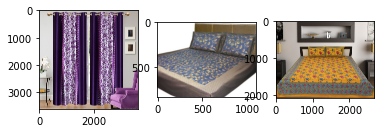

Computers
0   d1899ab1d5c79ddaa311bc9f04d198ed.jpg
1   b4d35b6536b623c83b293eb3a1c02bba.jpg
2   6329ddb46087cb8c09ced95471dd9643.jpg


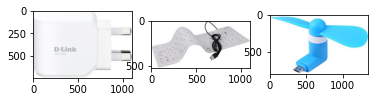

Watches
0   893aa5ed55f7cff2eccea7758d7a86bd.jpg
1   f355cc1ccb08bd0d283ed979b7ee7515.jpg
2   dd0e3470a7e6ed76fd69c2da27721041.jpg


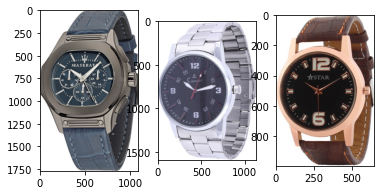

Kitchen & Dining
0   e9420e9483f16db81c64dddf99f34841.jpg
1   a3dea07b2f7bf48276d32513091be717.jpg
2   8050d31bffe6827c804b8222338aafb2.jpg


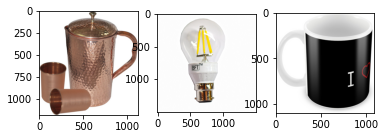

Beauty and Personal Care
0   2d50e4c6ccf8befe9335ac8f97a11712.jpg
1   02a53d335775b652f22f41b529b9d646.jpg
2   24e85c590481a7cedfe66597f253f2b2.jpg


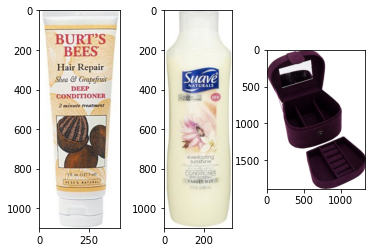

Baby Care
0   7b72c92c2f6c40268628ec5f14c6d590.jpg
1   64d5d4a258243731dc7bbb1eef49ad74.jpg
2   90e56526f4c5892beac49f262b85150a.jpg


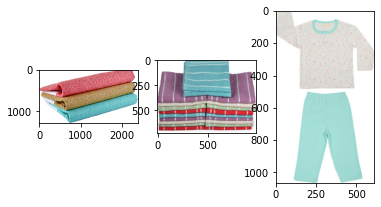

Home Decor & Festive Needs
0   f0938b0d88eac91deee6d5add54097d3.jpg
1   57578c1e6ec61a880a6f3f971f5f77b8.jpg
2   4e130ed339dcfe20d2c8b66892278a94.jpg


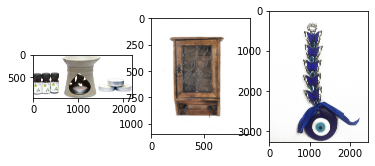

In [ ]:
from matplotlib.image import imread

for name in list_labels :
    print(name)
    img_test = df[df['product_category_tree_1']==name]['image'][:3]
    #img_test
    # print("-------")
    for i in range(3):
        plt.subplot(130 + 1 + i)
        #filename = list_fct(name)[i+10]
        print(i, ' ', img_test.iloc[i])
        filename = './Flipkart/Images/'+img_test.iloc[i]
        image = imread(filename)
        plt.imshow(image)
    plt.show()

<a name='3'></a>
# 3 SIFT, clustering et ARI

<a name='3.1'></a>
## 3.1 Détermination et affichage des descripteurs SIFT d'un image

* L'image contient 319 descripteurs
* Chaque descripteur est un vecteur de longueur 128

In [3]:
# In order to make xfeatures2d available run the following code
#pip install opencv-contrib-python

In [4]:
# Import the OpenCV library
import cv2

# Create an instance of the SIFT (Scale-Invariant Feature Transform) detector
sift = cv2.xfeatures2d.SIFT_create()


# Read an image from the specified path (using the second image in the list_photos)
file = df["image_path"][3]
image = cv2.imread(file, 0)  # Convert the image to grayscale
image2show = imread(file)
plt.imshow(image2show)

plt.show()

# Equalize the histogram of the image to enhance contrast
image = cv2.equalizeHist(image)

# Detect and compute SIFT keypoints and descriptors
kp, des = sift.detectAndCompute(image, None)
keyp = sift.detect(image, None)

# Draw the detected keypoints on the image
img = cv2.drawKeypoints(image, keyp, image)

# Display the image with keypoints
plt.imshow(img)
plt.show()

# Print information about the computed descriptors
print("Descripteurs : ", des.shape)
print()
print(des)

NameError: ignored

<a name='3.2'></a>
## 3.2 Classification d'images avec SIFT, bag-of-features et classification supervisée

<figure>
<img src="https://user.oc-static.com/upload/2018/03/13/15209802570047_methode_classif.png" alt="AnVIL Portal Image."/>
<figure-caption>Figure. Les trois étapes d'un algorithme de classification d'images.</figure-caption>
</figure>

Etape 1 : Extraction des features. On utilise seulement SIFT pour détecter et décrire les features.  
Etape 2 : Création des bag-of-features.  
Etape 3 : Classification Supervisée

<a name='3.3'></a>
## Pré-traitement des images via SIFT
### ETAPE 1: Créations des descripteurs de chaque image
* Pour chaque image passage en gris et equalisation
* création d'une liste de descripteurs par image ("sift_keypoints_by_img") qui sera utilisée pour réaliser les histogrammes par image
* création d'une liste de descripteurs pour l'ensemble des images ("sift_keypoints_all") qui sera utilisé pour créer les clusters de descripteurs

In [ ]:
num_photos = len(df["image_path"])
print("working on ", num_photos, " photos")

working on  1050  photos


In [ ]:
# identification of key points and associated descriptors
import time, cv2
sift_keypoints = []
temps1=time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for image_num in range(num_photos) :
    if image_num%100 == 0 : print(image_num)
    image = cv2.imread(df["image_path"][image_num],0) # convert in gray
    # image = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
    res = cv2.equalizeHist(image)   # equalize image histogram
    kp, des = sift.detectAndCompute(res, None)
    sift_keypoints.append(des)

sift_keypoints_by_img = np.asarray(sift_keypoints)
sift_keypoints_all    = np.concatenate(sift_keypoints_by_img, axis=0)

print()
print("Nombre de descripteurs : ", sift_keypoints_all.shape)

duration1=time.time()-temps1
print("temps de traitement SIFT descriptor : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000

Nombre de descripteurs :  (517351, 128)
temps de traitement SIFT descriptor :           274.28 secondes


<ipython-input-30-8db0dede73c0>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_by_img = np.asarray(sift_keypoints)


## ETAPE 2: Création des clusters de descripteurs (bag-of-features)
La création du "dictionnaire" des clusters visuels, se réalise en appliquant un algorithme de clustering aux descripteurs de features construits à l'étape 1, comme le k-means. Les visual words correspondent alors aux centres des clusters trouvés.

* Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [ ]:
from sklearn import cluster, metrics

# Determination number of clusters
temps1=time.time()

k = int(round(np.sqrt(len(sift_keypoints_all)),0))
print("Nombre de clusters estimés : ", k)
print("Création de",k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_all)

duration1=time.time()-temps1
print("temps de traitement kmeans : ", "%15.2f" % duration1, "secondes")

Nombre de clusters estimés :  719
Création de 719 clusters de descripteurs ...


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


temps de traitement kmeans :             4.21 secondes


## ETAPE 3: CLASSIFICATION SUPERVISEE


* Pour chaque image :
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [ ]:
# Creation of histograms (features)
temps1=time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des=len(des)
    if nb_des==0 : print("problème histogramme image  : ", image_num)
    for i in res:
        hist[i] += 1.0/nb_des
    return hist


# Creation of a matrix of histograms
hist_vectors=[]

for i, image_desc in enumerate(sift_keypoints_by_img) :
    if i%100 == 0 : print(i)
    hist = build_histogram(kmeans, image_desc, i) #calculates the histogram
    hist_vectors.append(hist) #histogram is the feature vector

im_features = np.asarray(hist_vectors)

duration1=time.time()-temps1
print("temps de création histogrammes : ", "%15.2f" % duration1, "secondes")

0
100
200
300
400
500
600
700
800
900
1000
temps de création histogrammes :             1.57 secondes


## Réductions de dimension
### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [ ]:
from sklearn import manifold, decomposition

print("Dimensions dataset avant réduction PCA : ", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(im_features)
print("Dimensions dataset après réduction PCA : ", feat_pca.shape)

Dimensions dataset avant réduction PCA :  (1050, 719)
Dimensions dataset après réduction PCA :  (1050, 495)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [ ]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30,
                     n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:,0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = df["product_category_tree_1"] #data["label_name"]
print(df_tsne.shape)

(1050, 3)


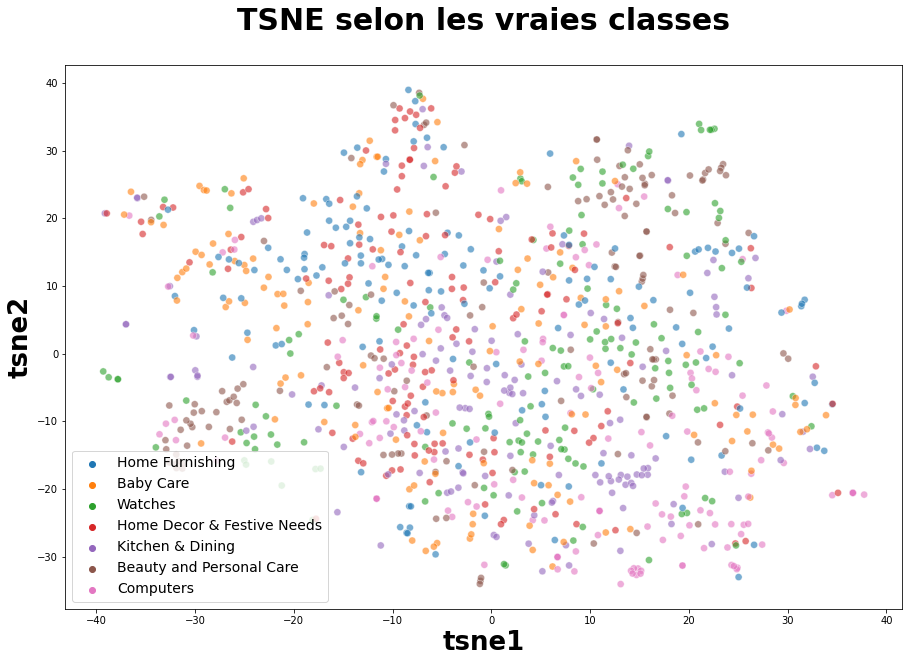

In [ ]:
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

## Analyse mesures : similarité entre catégories et clusters

In [ ]:
from sklearn import cluster, metrics

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_
print(df_tsne.shape)

(1050, 4)


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


###  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters
* Le score ARI de 0.03 est très faible

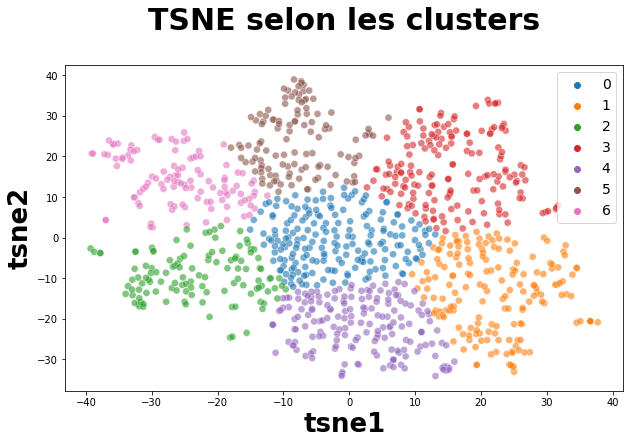

ARI :  0.0358257553902693


In [ ]:
plt.figure(figsize=(10,6))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les clusters', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

labels = df["label"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))

### Analyse par classes


In [ ]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    193
1    172
2    118
3    169
4    174
5    115
6    109
Name: class, dtype: int64

In [ ]:
conf_mat = metrics.confusion_matrix(labels, cls.labels_)
print(conf_mat)

[[26 19 10 15 25 21 34]
 [14 22 34 50 15  7  8]
 [27 54 13 12 34  4  6]
 [34 11 14 12 26 32 21]
 [23 16  6 29 15 38 23]
 [40 30 15 15 31  8 11]
 [29 20 26 36 28  5  6]]


In [ ]:
def conf_mat_transform(y_true,y_pred) :
    conf_mat = metrics.confusion_matrix(y_true,y_pred)

    # corresp = np.argmax(conf_mat, axis=0)
    corresp = [6, 5, 4, 3, 1, 2, 0]
    print ("Correspondance des clusters : ", corresp)
    # y_pred_transform = np.apply_along_axis(correspond_fct, 1, y_pred)
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x : corresp[x])

    return labels['y_pred_transform']

cls_labels_transform = conf_mat_transform(labels, cls.labels_)
conf_mat = metrics.confusion_matrix(labels, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels, cls_labels_transform))

Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
[[34 25 21 15 10 19 26]
 [ 8 15  7 50 34 22 14]
 [ 6 34  4 12 13 54 27]
 [21 26 32 12 14 11 34]
 [23 15 38 29  6 16 23]
 [11 31  8 15 15 30 40]
 [ 6 28  5 36 26 20 29]]

              precision    recall  f1-score   support

           0       0.31      0.23      0.26       150
           1       0.09      0.10      0.09       150
           2       0.03      0.03      0.03       150
           3       0.07      0.08      0.08       150
           4       0.05      0.04      0.04       150
           5       0.17      0.20      0.19       150
           6       0.15      0.19      0.17       150

    accuracy                           0.12      1050
   macro avg       0.13      0.12      0.12      1050
weighted avg       0.13      0.12      0.12      1050



<Axes: >

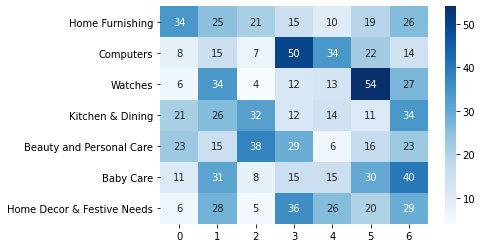

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,4))
sns.heatmap(df_cm, annot=True, cmap="Blues")

<a name='4'></a>
# 4 Etape 1 : étude de faisabilité d'une classification supervisée



<a name='4.0'></a>
## 4.0 Création du modéle préentrainé basé sur un VGG16

In [ ]:
# Import the VGG16 model, a pre-trained convolutional neural network for image classification.
# The model is imported from the Keras applications module.
base_model = VGG16()

# Create a new model that takes the same inputs as the VGG16 model
# but outputs the second-to-last layer's output (penultimate layer)
model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)

# Print a summary of the architecture and parameters of the newly created model
#print(model.summary())

<a name='4.1'></a>
## 4.1 Création des features des images

In [ ]:
# Create an empty list to store the extracted features from images
images_features = []

# Initialize a counter for tracking progress
i = 0

# Iterate through each image file path in the "image_path" column of the "data" DataFrame
for image_file in df["image_path"]:
    # Print progress every 100 images
    if i % 100 == 0:
        print(i)

    # Increment the counter
    i += 1

    # Load the image, resizing it to the target size of (224, 224)
    image = load_img(image_file, target_size=(224, 224))

    # Convert the image to a numpy array
    image = img_to_array(image)

    # Add an extra dimension to the image array to match the input shape expected by the model
    image = np.expand_dims(image, axis=0)

    # Preprocess the image data to align with the preprocessing used during training the model
    image = preprocess_input(image)

    # Use the pre-trained model to predict features from the preprocessed image
    # Append the predicted features to the list
    images_features.append(model.predict(image, verbose=0)[0])

# Convert the list of image features to a numpy array
images_features = np.asarray(images_features)

# Print the shape of the resulting array (number of images x number of features)
print(images_features.shape)

0
100
200
300
400
500
600


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


700
800
900
1000
(1050, 4096)


<a name='4.2'></a>
## 4.2 Réduction dimension et analyse

<a name='4.2.1'></a>
### 4.2.1 Réduction de dimension PCA

In [ ]:
from sklearn import manifold, decomposition

print(images_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca= pca.fit_transform(images_features)
print(feat_pca.shape)

(1050, 4096)
(1050, 803)


<a name='4.2.2'></a>
### 4.2.2 Réduction de dimension T-SNE et affichage des images selon vraies classes

In [ ]:
import time

temps1 = time.time()

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

duration1=time.time()-temps1
print("temps de T-SNE : ", "%15.2f" % duration1, "secondes")

temps de T-SNE :             3.65 secondes


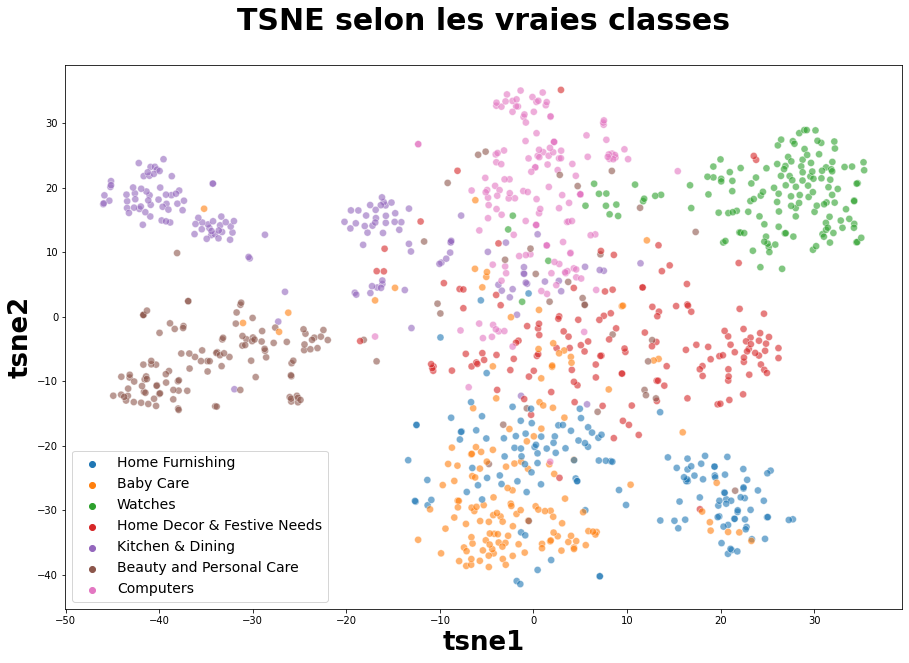

In [ ]:
df_tsne = pd.DataFrame(X_tsne, columns=['tsne1', 'tsne2'])
df_tsne["class"] = df['product_category_tree_1'] # data["label_name"]

plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="class",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

plt.title('TSNE selon les vraies classes', fontsize = 30, pad = 35, fontweight = 'bold')
plt.xlabel('tsne1', fontsize = 26, fontweight = 'bold')
plt.ylabel('tsne2', fontsize = 26, fontweight = 'bold')
plt.legend(prop={'size': 14})

plt.show()

todo kmeans + ari

<a name='5'></a>
# 5 Etape 2 : Classification Supervisée
4 approches sont présentées :
* 1 Une approche simple par préparation initiale de l'ensemble des images avant classification supervisée
* 2 Une approche par data generator, permettant facilement la data augmentation. Les images sont directement récupérées à la volée dans le repertoire des images
* 3 Une approche récente proposée par Tensorflow.org par DataSet, sans data augmentation
* 4 Une approche par  DataSet, avec data augmentation intégrée au modèle : layer en début de modèle


## Création du modèle de classification

In [ ]:
# Define a function to create a custom model based on VGG16
def create_model_fct():
    # Retrieve a pre-trained VGG16 model without the top classification layer
    model0 = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))

    # Set all layers of the pre-trained model to non-trainable
    for layer in model0.layers:
        layer.trainable = False

    # Get the output of the pre-trained model
    x = model0.output


    # Add additional layers to the model
    # Part of the network that does the classification
    x = GlobalAveragePooling2D()(x)  # Global average pooling layer
    x = Dense(256, activation='relu')(x)  # Fully connected layer with ReLU activation
    x = Dropout(0.5)(x)  # Dropout layer to reduce overfitting
    predictions = Dense(7, activation='softmax')(x)  # Output layer with softmax activation

    # Define the new model with the added layers
    model = Model(inputs=model0.input, outputs=predictions)

    # Compile the model with categorical crossentropy loss, rmsprop optimizer, and accuracy metric
    model.compile(loss="categorical_crossentropy", optimizer='rmsprop', metrics=["accuracy"])

    # Print a summary of the model architecture
    print(model.summary())

    # Return the created model
    return model

## 1 Approche préparation initiale des images

In [ ]:
# Specify the fraction of data to allocate to the second part (e.g., 0.2 for 20%)
test_size = 0.2

# Use train_test_split to randomly split the DataFrame
df_train, df_test = train_test_split(df, test_size=test_size, random_state=42)

df_train.reset_index(inplace=True)
df_test.reset_index(inplace=True)
# Display the shapes of the two parts
print("Shape of Part 1:", df_train.shape)
print("Shape of Part 2:", df_test.shape)

Shape of Part 1: (840, 20)
Shape of Part 2: (210, 20)


In [ ]:
def image_prep_fct(data) :
    prepared_images = []
    for image_num in range(len(data['image_path'])) :
        img = (load_img(
            data['image_path'][image_num],
            target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        img = preprocess_input(img)
        prepared_images.append(img)
        prepared_images_np = np.array(prepared_images)
    return prepared_images_np

images_np = image_prep_fct(df_train)
print(images_np.shape)
images_np_test = image_prep_fct(df_test)
print(images_np_test.shape)

(840, 224, 224, 3)


/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(210, 224, 224, 3)


In [ ]:
df_train.head(2)

,index,uniq_id,crawl_timestamp,product_url,product_name,product_category_tree,pid,retail_price,discounted_price,image,is_FK_Advantage_product,description,product_rating,overall_rating,brand,product_specifications,product_category_tree_1,image_path,label
0,554,b144a363c107c7bdd91f32d6e28ba6f2,2016-01-07 05:50:25 +0000,http://www.flipkart.com/timewel-1100-n1192-ana...,Timewel 1100-N1192 Analog Watch - For Men,"[""Watches >> Wrist Watches >> Timewel Wrist Wa...",WATEYAP38HHARJDT,995.0,995.0,b144a363c107c7bdd91f32d6e28ba6f2.jpg,False,Timewel 1100-N1192 Analog Watch - For Men - B...,No rating available,No rating available,NaN,"{""product_specification""=>[{""key""=>""Mechanism""...",Watches,./Flipkart/Images/b144a363c107c7bdd91f32d6e28b...,6
1,1012,29def171d7e31d48571a52f0fb3e6b07,2016-03-02 19:09:22 +0000,http://www.flipkart.com/ech-oly-ceramic-inside...,Ech oly Ceramic Inside Fitting Hookah Mouth Tip,"[""Home Decor & Festive Needs >> Table Decor & ...",HMTEFW3SGGF9HYPT,1799.0,699.0,29def171d7e31d48571a52f0fb3e6b07.jpg,False,Ech oly Ceramic Inside Fitting Hookah Mouth Ti...,No rating available,No rating available,Ech oly,"{""product_specification""=>[{""key""=>""Brand"", ""v...",Home Decor & Festive Needs,./Flipkart/Images/29def171d7e31d48571a52f0fb3e...,3


In [ ]:
X = images_np
y = to_categorical(df_train['label'])

X_test = images_np_test
y_test = to_categorical(df_test['label'])

y

array([[0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)
X_train.shape

(630, 224, 224, 3)

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model1 = create_model_fct()

# Création du callback
model1_save_path1 = "./Output/model1_best_weights.h5"
checkpoint = ModelCheckpoint(model1_save_path1, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print(X_val.shape)
print(y_val.shape)
print(X_train.shape)
print(y_train.shape)

(210, 224, 224, 3)
(210, 7)
(630, 224, 224, 3)
(630, 7)


In [ ]:
# Entraîner sur les données d'entraînement (X_train, y_train)
with tf.device('/gpu:0'):
    history1 = model1.fit(X_train, y_train, epochs=50, batch_size=64,
                       callbacks=callbacks_list, validation_data=(X_val, y_val), verbose=1)


Epoch 1/50
10/10 [==============================] - ETA: 0s - loss: 5.4274 - accuracy: 0.4476
Epoch 1: val_loss improved from inf to 1.68068, saving model to ./Output/model1_best_weights.h5
10/10 [==============================] - 62s 6s/step - loss: 5.4274 - accuracy: 0.4476 - val_loss: 1.6807 - val_accuracy: 0.7095
Epoch 2/50
10/10 [==============================] - ETA: 0s - loss: 2.1682 - accuracy: 0.6730
Epoch 2: val_loss improved from 1.68068 to 1.46364, saving model to ./Output/model1_best_weights.h5
10/10 [==============================] - 63s 6s/step - loss: 2.1682 - accuracy: 0.6730 - val_loss: 1.4636 - val_accuracy: 0.7571
Epoch 3/50
10/10 [==============================] - ETA: 0s - loss: 1.5141 - accuracy: 0.7333
Epoch 3: val_loss improved from 1.46364 to 1.31384, saving model to ./Output/model1_best_weights.h5
10/10 [==============================] - 62s 6s/step - loss: 1.5141 - accuracy: 0.7333 - val_loss: 1.3138 - val_accuracy: 0.7476
Epoch 4/50
10/10 [=================

In [ ]:
# Score du dernier epoch

loss, accuracy = model1.evaluate(X_train, y_train, verbose=True)
print("Training Accuracy: {:.4f}".format(accuracy))
print()
loss, accuracy = model1.evaluate(X_val, y_val, verbose=True)
print("Validation Accuracy:  {:.4f}".format(accuracy))

20/20 [==============================] - 48s 2s/step - loss: 0.0117 - accuracy: 0.9968
Training Accuracy: 0.9968

7/7 [==============================] - 16s 2s/step - loss: 1.0695 - accuracy: 0.7762
Validation Accuracy:  0.7762


In [ ]:
# Score de l'epoch optimal

model1.load_weights(model1_save_path1)

loss, accuracy = model1.evaluate(X_val, y_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model1.evaluate(X_test, y_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8143
Test Accuracy       :  0.8238


In [ ]:
#pip install plot_keras_history


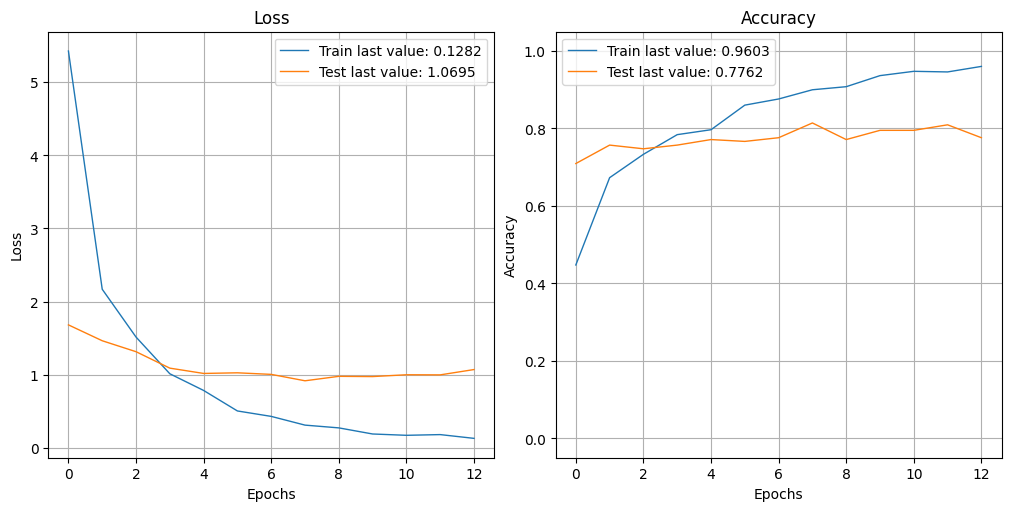

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history1)
plot_history(history1, path="standard.png")
plt.close()

In [ ]:
y_val_num = np.argmax(y_val, axis=1)
y_val_pred = np.argmax(model1.predict(X_val), axis=1)
y_val_num = np.argmax(y_val, axis=1)
print(y_val_num)
print()
print(y_val_pred)

7/7 [==============================] - 16s 2s/step
[3 6 2 6 3 5 4 0 0 2 6 0 1 5 6 3 1 1 6 0 1 2 6 3 3 0 4 4 2 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 0 6 6 5 0 4 1 5 4 5 0 2 6 5 5 1 4 4 5 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 1 5 3 4 2 0 3 5 2 5 3 4 3 4 6 1 2 5 0 4 6 3 5 1 1 5 3 1 1 1 2 2 3
 5 4 2 5 4 2 6 0 2 0 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 1 2 6 3 6 5 1 1 6
 6 0 0 5 3 4 3 3 5 1 3 1 4 5 6 5 0 4 0 6 1 0 4 0 2 1 4 0 2 4 0 5 2 4 0 1 0
 5 2 4 0 2 2 1 6 1 4 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]

[3 6 4 6 3 0 0 3 5 2 6 0 1 5 6 3 1 1 6 0 1 5 6 3 3 0 4 4 1 0 2 4 6 5 0 6 4
 5 1 1 5 6 1 1 6 2 1 0 1 1 3 4 5 0 1 6 5 5 1 0 4 1 3 6 3 3 6 0 3 5 3 2 5 3
 3 3 2 6 5 5 3 4 2 0 3 5 2 5 3 0 3 4 6 1 6 5 0 4 5 3 5 1 3 5 3 1 1 1 2 2 0
 5 4 2 5 4 2 2 0 2 3 3 2 4 5 3 1 3 3 0 0 4 2 1 6 1 1 4 2 6 3 6 3 6 5 1 1 6
 2 1 0 5 3 4 3 3 5 1 5 1 0 1 6 3 0 4 5 6 1 0 4 4 2 1 4 2 2 4 4 5 1 4 0 1 0
 5 2 4 2 3 2 1 6 1 0 2 4 3 1 1 6 2 0 6 0 4 0 6 5 5]


In [ ]:
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred)
print(conf_mat)

[[21  2  2  2  2  2  0]
 [ 0 29  0  1  0  1  1]
 [ 0  3 20  2  1  1  1]
 [ 1  0  0 28  0  1  0]
 [ 5  1  0  0 23  0  0]
 [ 1  3  0  2  0 25  0]
 [ 0  0  3  0  0  1 25]]


In [ ]:
y_val_pred_transform = conf_mat_transform(y_val_num, y_val_pred)
conf_mat = metrics.confusion_matrix(y_val_num, y_val_pred_transform)
print(conf_mat)
print()
print(metrics.classification_report(y_val_num, y_val_pred_transform))

Correspondance des clusters :  [6, 5, 4, 3, 1, 2, 0]
[[ 0  2  2  2  2  2 21]
 [ 1  0  1  1  0 29  0]
 [ 1  1  1  2 20  3  0]
 [ 0  0  1 28  0  0  1]
 [ 0 23  0  0  0  1  5]
 [ 0  0 25  2  0  3  1]
 [25  0  1  0  3  0  0]]

              precision    recall  f1-score   support

           0       0.00      0.00      0.00        31
           1       0.00      0.00      0.00        32
           2       0.03      0.04      0.03        28
           3       0.80      0.93      0.86        30
           4       0.00      0.00      0.00        29
           5       0.08      0.10      0.09        31
           6       0.00      0.00      0.00        29

    accuracy                           0.15       210
   macro avg       0.13      0.15      0.14       210
weighted avg       0.13      0.15      0.14       210



<Axes: >

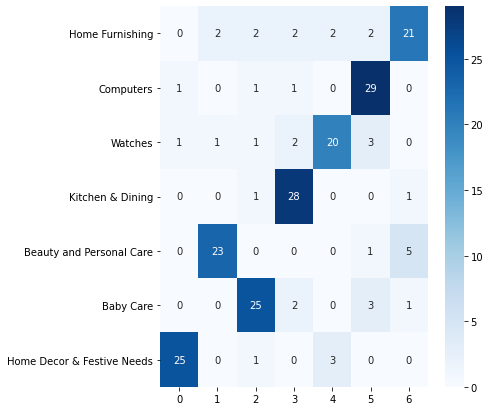

In [ ]:
df_cm = pd.DataFrame(conf_mat, index = [label for label in list_labels],
                  columns = [i for i in "0123456"])
plt.figure(figsize = (6,7))
sns.heatmap(df_cm, annot=True, cmap="Blues")

## Approche ImageDatagenerator avec data augmentation

CF https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator#flow (noté désormais comme "deprecated", incite à utiiser l'approche suivante)

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
# Pour mélanger les images, classées initalement par classe
data = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [ ]:
batch_size = 32

def data_flow_fct(data, datagen, data_type=None) :
    data_flow = datagen.flow_from_dataframe(data, directory='',
                                x_col='image_path', y_col='product_category_tree_1',
                                weight_col=None, target_size=(256, 256),
                                classes=None, class_mode='categorical',
                                batch_size=batch_size, shuffle=True, seed=42,
                                subset=data_type
                                )
    return data_flow

In [ ]:
datagen_train = ImageDataGenerator(
#    featurewise_center=True,
#    featurewise_std_normalization=True,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    validation_split=0.25,
    preprocessing_function=preprocess_input)

train_flow = data_flow_fct(data, datagen_train, data_type='training')
val_flow = data_flow_fct(data, datagen_train, data_type='validation')

datagen_test = ImageDataGenerator(
    validation_split=0,
    preprocessing_function=preprocess_input)

test_flow = data_flow_fct(df_test, datagen_test, data_type=None)

# compute quantities required for featurewise normalization
# (std, mean, and principal components if ZCA whitening is applied)
# datagen.fit(X_train)
# fits the model on batches with real-time data augmentation:

Found 788 validated image filenames belonging to 7 classes.
Found 262 validated image filenames belonging to 7 classes.
Found 210 validated image filenames belonging to 7 classes.


In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model2 = create_model_fct()

# Création du callback
model2_save_path = "./model2_best_weights.h5"
checkpoint = ModelCheckpoint(model2_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'):
    history2 = model2.fit(train_flow,
                    validation_data=val_flow,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
25/25 [==============================] - ETA: 0s - loss: 4.0367 - accuracy: 0.4518

/Users/markobriesemann/opt/anaconda3/lib/python3.8/site-packages/PIL/Image.py:2834: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(



Epoch 1: val_loss improved from inf to 1.13662, saving model to ./model2_best_weights.h5
25/25 [==============================] - 113s 5s/step - loss: 4.0367 - accuracy: 0.4518 - val_loss: 1.1366 - val_accuracy: 0.7595
Epoch 2/50
25/25 [==============================] - ETA: 0s - loss: 1.6832 - accuracy: 0.6599
Epoch 2: val_loss improved from 1.13662 to 0.99670, saving model to ./model2_best_weights.h5
25/25 [==============================] - 112s 4s/step - loss: 1.6832 - accuracy: 0.6599 - val_loss: 0.9967 - val_accuracy: 0.7481
Epoch 3/50
25/25 [==============================] - ETA: 0s - loss: 1.0781 - accuracy: 0.7284
Epoch 3: val_loss improved from 0.99670 to 0.91449, saving model to ./model2_best_weights.h5
25/25 [==============================] - 112s 4s/step - loss: 1.0781 - accuracy: 0.7284 - val_loss: 0.9145 - val_accuracy: 0.7863
Epoch 4/50
25/25 [==============================] - ETA: 0s - loss: 0.8050 - accuracy: 0.7766
Epoch 4: val_loss improved from 0.91449 to 0.86801, 

In [ ]:
# Score du dernier epoch

loss, accuracy = model2.evaluate(train_flow, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model2.evaluate(val_flow, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 5s 527ms/step - loss: 0.0232 - accuracy: 0.9933
Training Accuracy   : 0.9933

4/4 [==============================] - 2s 399ms/step - loss: 0.1789 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [ ]:
# Score de l'epoch optimal

model2.load_weights(model2_save_path)

loss, accuracy = model2.evaluate(val_flow, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model2.evaluate(test_flow, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8053
Test Accuracy       :  0.8238


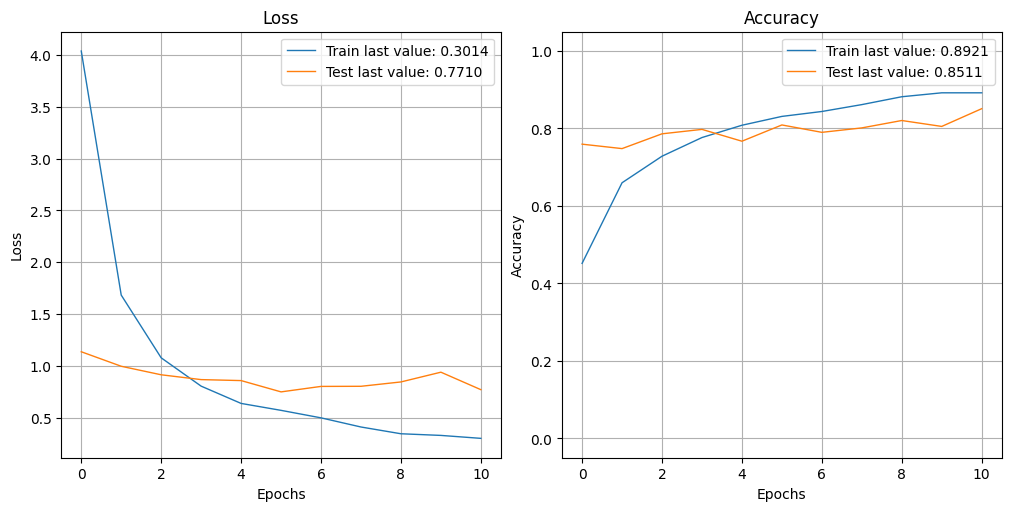

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history2)
plot_history(history2, path="standard.png")
plt.close()

## 3 Approche nouvelle par Dataset sans data augmentation

CF https://www.tensorflow.org/tutorials/load_data/images

In [ ]:

# import module
import shutil

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    print(path)
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path,
                    labels='inferred', label_mode='categorical',
                    #class_names=None,
                    batch_size=32, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset

In [ ]:
try:
    os.mkdir('./Flipkart/TRAIN')
except OSError as error:
    print(error)

for i in class_folder_name:
    #print(i)
    try:
        os.mkdir('./Flipkart/TRAIN/'+str(i))
    except OSError as error:
        print(error)

for i in range(df_train.shape[0]):
    #print("i ", i)
    # copy the contents of the
    shutil.copyfile(df_train['image_path'][i], './Flipkart/TRAIN/'+df_train['product_category_tree_1'][i]+'/'+df_train['image'][i])


[Errno 17] File exists: './Flipkart/TRAIN'


In [ ]:
class_folder_name = set(df['product_category_tree_1'])

try:
    os.mkdir('./Flipkart/TEST')
except OSError as error:
    print(error)

for i in class_folder_name:
    print(i)
    try:
        os.mkdir('./Flipkart/TEST/'+str(i))
    except OSError as error:
        print(error)

for i in range(df_test.shape[0]):
    #print("i ", i)
    # copy the contents of the
    shutil.copyfile(df_test['image_path'][i], './Flipkart/TEST/'+df_test['product_category_tree_1'][i]+'/'+df_test['image'][i])


[Errno 17] File exists: './Flipkart/TEST'
Home Furnishing
Computers
Watches
Kitchen & Dining
Beauty and Personal Care
Baby Care
Home Decor & Festive Needs


In [ ]:
path_train = './Flipkart/TRAIN/'
path_test = './Flipkart/TEST/'

In [ ]:
dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

./Flipkart/TRAIN/
Found 840 files belonging to 7 classes.
Using 630 files for training.
./Flipkart/TRAIN/
Found 840 files belonging to 7 classes.
Using 210 files for validation.
./Flipkart/TEST/
Found 210 files belonging to 7 classes.


In [ ]:

class_names = dataset_test.class_names
print(class_names)

['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']


['Baby Care', 'Beauty and Personal Care', 'Computers', 'Home Decor & Festive Needs', 'Home Furnishing', 'Kitchen & Dining', 'Watches']
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32) label index  0
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32) label index  4
tf.Tensor([1. 0. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32) label index  0
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32) label index  6
tf.Tensor([0. 1. 0. 0. 0. 0. 0.], shape=(7,), dtype=float32) label index  1
tf.Tensor([0. 0. 0. 0. 0. 0. 1.], shape=(7,), dtype=float32) label index  6
tf.Tensor([0. 0. 0. 1. 0. 0. 0.], shape=(7,), dtype=float32) label index  3
tf.Tensor([0. 0. 1. 0. 0. 0. 0.], shape=(7,), dtype=float32) label index  2
tf.Tensor([0. 0. 0. 0. 1. 0. 0.], shape=(7,), dtype=float32) label index  4


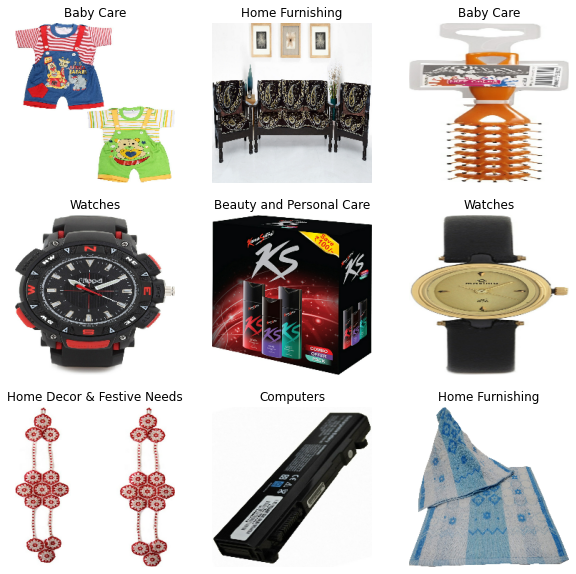

In [ ]:
import matplotlib.pyplot as plt

print(class_names)
plt.figure(figsize=(10, 10))
for images, labels in dataset_test.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Convert the labels tensor to a NumPy array and then use it as an index
        label_index = tf.argmax(labels[i]).numpy()
        print(labels[i], 'label index ',label_index)
        plt.title(class_names[label_index])
        plt.axis("off")

In [ ]:
# Création du modèle
with tf.device('/gpu:0'):
    model3 = create_model_fct()

# Création du callback
model3_save_path = "./model3_best_weights.h5"
checkpoint = ModelCheckpoint(model3_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'):
    history3 = model3.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)


Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 6.5592 - accuracy: 0.4444
Epoch 1: val_loss improved from inf to 1.73490, saving model to ./model3_best_weights.h5
20/20 [==============================] - 75s 4s/step - loss: 6.5592 - accuracy: 0.4444 - val_loss: 1.7349 - val_accuracy: 0.6857
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 2.2379 - accuracy: 0.6746
Epoch 2: val_loss improved from 1.73490 to 1.41611, saving model to ./model3_best_weights.h5
20/20 [==============================] - 78s 4s/step - loss: 2.2379 - accuracy: 0.6746 - val_loss: 1.4161 - val_accuracy: 0.7476
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.2047 - accuracy: 0.7730
Epoch 3: val_loss did not improve from 1.41611
20/20 [==============================] - 75s 4s/step - loss: 1.2047 - accuracy: 0.7730 - val_loss: 1.5062 - val_accuracy: 0.7143
Epoch 4/50
20/20 [==============================] - ETA: 0s - loss: 0.8994 - accuracy: 0.7952
Epoch 4:

In [ ]:
# Score du dernier epoch

loss, accuracy = model3.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model3.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

20/20 [==============================] - 48s 2s/step - loss: 0.0140 - accuracy: 0.9984
Training Accuracy   : 0.9984

7/7 [==============================] - 17s 2s/step - loss: 1.4349 - accuracy: 0.7762
Validation Accuracy :  0.7762


In [ ]:
# Score de l'epoch optimal

model3.load_weights(model3_save_path)

loss, accuracy = model3.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model3.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.8048
Test Accuracy       :  0.8095


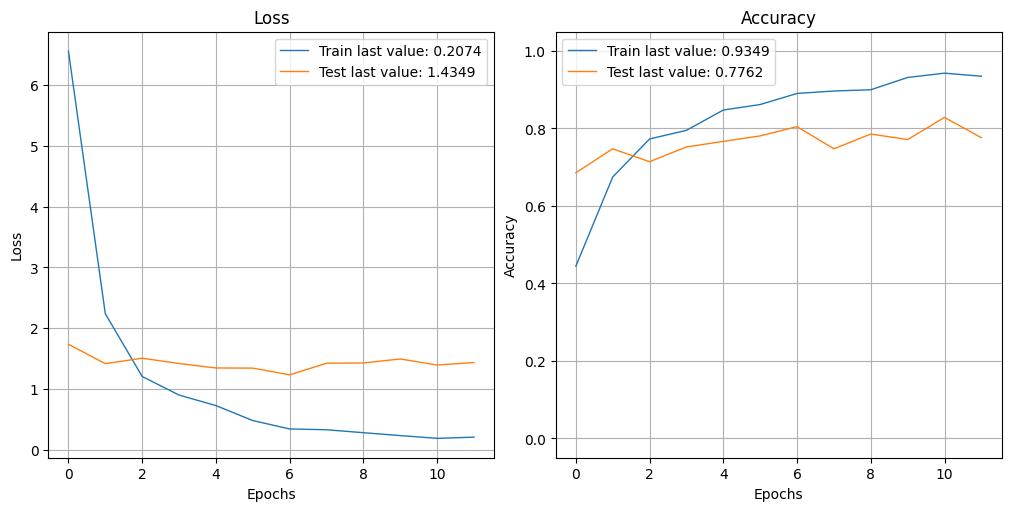

In [ ]:
from plot_keras_history import show_history, plot_history
import matplotlib.pyplot as plt

show_history(history3)
plot_history(history3, path="standard.png")
plt.close()

## 4 Approche nouvelle par Dataset avec data augmentation intégrée au modèle

CF https://www.tensorflow.org/tutorials/images/data_augmentation

In [ ]:
batch_size = 32

def dataset_fct(path, validation_split=0, data_type=None) :
    dataset = tf.keras.utils.image_dataset_from_directory(
                    path, labels='inferred', label_mode='categorical',
                    class_names=None,
                    batch_size=batch_size, image_size=(224, 224), shuffle=True, seed=42,
                    validation_split=validation_split, subset=data_type
                    )
    return dataset



In [ ]:
#dataset_train = dataset_fct(path_train, validation_split=0.25, data_type='training')
#dataset_val = dataset_fct(path_train, validation_split=0.25, data_type='validation')
#dataset_test = dataset_fct(path_test, validation_split=0, data_type=None)

In [ ]:
def resize_and_rescale(image, label):
    image = tf.cast(image, tf.float32)
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])
    image = (image / 255.0)
    return image, label

In [ ]:
def create_model_fct2() :
    # Data augmentation
    data_augmentation = Sequential([
        RandomFlip("horizontal", input_shape=(224, 224, 3)),
        RandomRotation(0.1),
        RandomZoom(0.1),
        # Rescaling(1./127.5, offset=-1.0)
      ])

    # Récupération modèle pré-entraîné
    model_base = VGG16(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
    for layer in model_base.layers:
        layer.trainable = False

    # Définition du nouveau modèle
    model = Sequential([
                data_augmentation,
                Rescaling(1./127.5, offset=-1),
                model_base,
                GlobalAveragePooling2D(),
                Dense(256, activation='relu'),
                Dropout(0.5),
                Dense(7, activation='softmax')
                ])

    # compilation du modèle
    model.compile(loss="categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

    print(model.summary())

    return model


# Création du modèle
with tf.device('/gpu:0'):
    model4 = create_model_fct2()

# Création du callback
model4_save_path = "./model4_best_weights.h5"
checkpoint = ModelCheckpoint(model4_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, es]


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_2 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 rescaling_1 (Rescaling)     (None, 224, 224, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d_7   (None, 512)              0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense_14 (Dense)            (None, 256)               131328    
                                                                 
 dropout_7 (Dropout)         (None, 256)               0         
                                                      

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [ ]:
with tf.device('/gpu:0'):
    history4 = model4.fit(dataset_train,
                    validation_data=dataset_val,
                    batch_size=batch_size, epochs=50, callbacks=callbacks_list, verbose=1)

Epoch 1/50
20/20 [==============================] - ETA: 0s - loss: 1.8654 - accuracy: 0.2667
Epoch 1: val_loss improved from inf to 1.43055, saving model to ./model4_best_weights.h5
20/20 [==============================] - 74s 4s/step - loss: 1.8654 - accuracy: 0.2667 - val_loss: 1.4306 - val_accuracy: 0.5619
Epoch 2/50
20/20 [==============================] - ETA: 0s - loss: 1.4153 - accuracy: 0.5254
Epoch 2: val_loss improved from 1.43055 to 1.09741, saving model to ./model4_best_weights.h5
20/20 [==============================] - 74s 4s/step - loss: 1.4153 - accuracy: 0.5254 - val_loss: 1.0974 - val_accuracy: 0.7238
Epoch 3/50
20/20 [==============================] - ETA: 0s - loss: 1.1549 - accuracy: 0.6349
Epoch 3: val_loss improved from 1.09741 to 0.95759, saving model to ./model4_best_weights.h5
20/20 [==============================] - 79s 4s/step - loss: 1.1549 - accuracy: 0.6349 - val_loss: 0.9576 - val_accuracy: 0.7333
Epoch 4/50
20/20 [==============================] - ETA:

Epoch 20/50
20/20 [==============================] - ETA: 0s - loss: 0.5262 - accuracy: 0.8397
Epoch 20: val_loss did not improve from 0.64794
20/20 [==============================] - 69s 3s/step - loss: 0.5262 - accuracy: 0.8397 - val_loss: 0.6565 - val_accuracy: 0.8333
Epoch 21/50
20/20 [==============================] - ETA: 0s - loss: 0.5270 - accuracy: 0.8302
Epoch 21: val_loss did not improve from 0.64794
20/20 [==============================] - 301s 16s/step - loss: 0.5270 - accuracy: 0.8302 - val_loss: 0.6727 - val_accuracy: 0.8143
Epoch 22/50
20/20 [==============================] - ETA: 0s - loss: 0.5005 - accuracy: 0.8413
Epoch 22: val_loss did not improve from 0.64794
20/20 [==============================] - 74s 4s/step - loss: 0.5005 - accuracy: 0.8413 - val_loss: 0.6510 - val_accuracy: 0.8143
Epoch 23/50
20/20 [==============================] - ETA: 0s - loss: 0.4912 - accuracy: 0.8492
Epoch 23: val_loss improved from 0.64794 to 0.64488, saving model to ./model4_best_weig

In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 2s 95ms/step - loss: 0.0652 - accuracy: 0.9967
Training Accuracy   : 0.9967

4/4 [==============================] - 0s 75ms/step - loss: 0.1619 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9400
Test Accuracy       :  0.9000


In [ ]:
# Score du dernier epoch

loss, accuracy = model4.evaluate(dataset_train, verbose=True)
print("Training Accuracy   : {:.4f}".format(accuracy))
print()
loss, accuracy = model4.evaluate(dataset_val, verbose=True)
print("Validation Accuracy :  {:.4f}".format(accuracy))

10/10 [==============================] - 2s 95ms/step - loss: 0.0652 - accuracy: 0.9967
Training Accuracy   : 0.9967

4/4 [==============================] - 0s 75ms/step - loss: 0.1619 - accuracy: 0.9400
Validation Accuracy :  0.9400


In [ ]:
# Score de l'epoch optimal

model4.load_weights(model4_save_path)

loss, accuracy = model4.evaluate(dataset_val, verbose=False)
print("Validation Accuracy :  {:.4f}".format(accuracy))

loss, accuracy = model4.evaluate(dataset_test, verbose=False)
print("Test Accuracy       :  {:.4f}".format(accuracy))


Validation Accuracy :  0.9400
Test Accuracy       :  0.9000
